# Supervised (age) regression models

Train `RandomForestRegressor` models on 
  - merged latent space of all chromosomes
  
  
Trained using external script because of heavy computation load!

In [1]:
import pandas as pd
import numpy as np
import os
import pickle 
import json
import torch
from data.prepareData import prepareDataLoader_fromPkl
from scripts.train_RFregressor import RFregression
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import mannwhitneyu

sns.set_theme(style="ticks", font_scale=1.3)

c_high = sns.color_palette("Blues")[5]
c_low = sns.color_palette("Blues")[3]
c_none = sns.color_palette("Blues")[1]

In [2]:
all_cpgs = {"high":[],"low":[],"none":[]}

'''
Get globally connected CpGs of all chromosomes
'''
for CHR in [f"chr{i}" for i in range(1,23)]:
    #print(CHR)
    PATH_data = "/data/scratch/skatz/PROJECTS/methylnet/1_healthyVAE/data/GSE87571/train_val_test_sets/"
    PATH_model= f"logs/finalModels/{CHR}"
    PATH_perturbation = f"results/{CHR}/perturbations"

    # Load beta matrix
    #with open(os.path.join(PATH_data, "chr22_wholeDataset.pkl"), "rb") as f: whole_dataset = pickle.load(f) #

    # Load CpG connections
    #conn = pd.read_csv(f"{PATH_perturbation}/quantileCutoff_CpGfocus.csv", index_col=0)
    with open(f"{PATH_perturbation}/global_connectivity_groups.pkl", "rb") as f: dic_globalConn = pickle.load(f)
    chr_idx_cpgs_high = dic_globalConn["global_high"]
    chr_idx_cpgs_low = dic_globalConn["global_low"]
    chr_idx_cpgs_none = dic_globalConn["global_none"]
    #print(f"High CpGs: {len(chr_idx_cpgs_high)}\nLow CpGs: {len(chr_idx_cpgs_low)}\nNone CpGs: {len(chr_idx_cpgs_none)}\n")
    
    all_cpgs["high"]+=chr_idx_cpgs_high
    all_cpgs["low"]+=chr_idx_cpgs_low
    all_cpgs["none"]+=chr_idx_cpgs_none

print(f"\n\nAll Chromosomes - High CpGs: {len(all_cpgs['high'])}\nAll Chromosomes - Low CpGs: {len(all_cpgs['low'])}\nAll Chromosomes - None CpGs: {len(all_cpgs['none'])}\n")



All Chromosomes - High CpGs: 30949
All Chromosomes - Low CpGs: 181798
All Chromosomes - None CpGs: 87253



In [3]:
''' Prediction using CPGs identified by the AE '''
r2_ae = {}
for group in ["high", "low", "none"]:
    ''' load data ''' 
    with open(os.path.join(PATH_data, f"test_methyl_array.pkl"), "rb") as f: test_dataset = pickle.load(f) #
    test_dataset_beta = test_dataset["beta"].loc[:,all_cpgs[group]]
    X_test = test_dataset_beta
    y_test = test_dataset["pheno"]["Age"].values
    mask_test = ~np.isnan(y_test)
    X_test = X_test[mask_test]
    y_test = y_test[mask_test]
    
    ''' get R2 '''
    PATH_regr = f"logs/finalModels/globalCpGs_{group}/regression/RFregressor.sav"
    with open(f"{PATH_regr}", "rb") as f: regr = pickle.load(f)
    r2 = regr.score(X_test, y_test)  # coefficient of determination
    r2_ae[group] = r2
    
r2_ae

{'high': 0.9340920511241709,
 'low': 0.9062375076995268,
 'none': 0.8462452275294563}

In [4]:
''' Get Bootstrapping results'''

r2_bootstrap = {"r2_high":[], "r2_low":[], "r2_none":[]}
PATH_results = "results/globalCpGs/prediction/age"
for i in range(1,7):
    with open(f"{PATH_results}/globalCpGs_regressionBootstrap_r2_{i}.pkl", "rb") as f: data = pickle.load(f)
    for key in data.keys():
        r2_bootstrap[key]+=data[key]

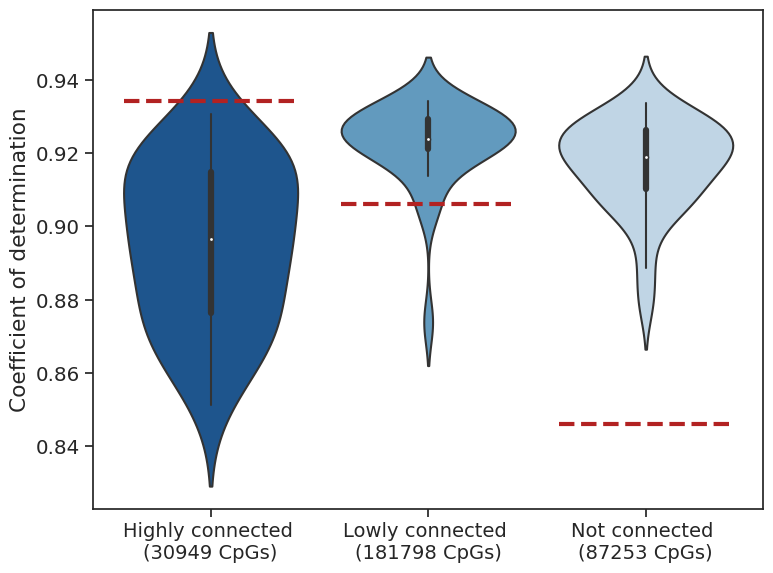

In [165]:
''' print <3 '''
fontsize = 20

df_bootstrap = pd.DataFrame.from_dict(r2_bootstrap).melt()

fig, ax = plt.subplots(figsize=(8,6))
sns.violinplot(data=df_bootstrap, x="variable", y="value", hue="variable", dodge=False, legend=False, palette=[c_high, c_low, c_none], ax=ax)
ax.hlines(xmin=-0.4, xmax=0.4, y=r2_ae["high"], linestyle="dashed", linewidth=3, color="firebrick", label="CpGs derived through AE")
ax.hlines(xmin=.6, xmax=1.4, y=r2_ae["low"], linestyle="dashed", linewidth=3, color="firebrick")
ax.hlines(xmin=1.6, xmax=2.4, y=r2_ae["none"], linestyle="dashed", linewidth=3, color="firebrick")
ax.set_xlabel("")
ax.set_ylabel("Coefficient of determination")
ax.set_xticklabels([f"Highly connected \n({len(all_cpgs_high)} CpGs)",
                    f"Lowly connected \n({len(all_cpgs_low)} CpGs)",
                    f"Not connected \n({len(all_cpgs_none)} CpGs)"], fontsize=fontsize-6)
ax.get_legend().remove()
#ax.legend(bbox_to_anchor=(1.02, 1.02))
plt.tight_layout()
plt.savefig(f"figures/global_connectivity_supervisedPrediction.png")

In [16]:
numBootstrap = len(r2_bootstrap["r2_high"])

### Validate significance level in % iterations higher than our value
hits_high = pd.Series(r2_bootstrap["r2_high"] >= r2_ae["high"]).value_counts()
print(f"\tHigh connectivity: \n{hits_high}")
try: 
    print(f"\tBootstrap p-Value: {(hits_high[1]/numBootstrap)} \n")
except KeyError:
    print(f"\tBootstrap p-Value: {(0/numBootstrap)} \n")
    

hits_low = pd.Series(r2_bootstrap["r2_low"] >= r2_ae["low"]).value_counts()
print(f"\tLow connectivity: \n{hits_low}")
print(f"\tBootstrap p-Value: {(hits_low[1]/numBootstrap)} \n")


hits_none = pd.Series(r2_bootstrap["r2_none"] >= r2_ae["none"]).value_counts()
print(f"\tNone connectivity: \n{hits_none}")
print(f"\tBootstrap p-Value: {(hits_none[1]/numBootstrap)} \n")

	High connectivity: 
False    30
dtype: int64
	Bootstrap p-Value: 0.0 

	Low connectivity: 
True     27
False     3
dtype: int64
	Bootstrap p-Value: 0.9 

	None connectivity: 
True    30
dtype: int64
	Bootstrap p-Value: 1.0 



In [15]:
numBootstrap

30